In [230]:
import requests
import json
from credentials import CREDENTIALS

AUTH_URL = 'https://swift.oit.duke.edu/auth/v1.0/'

In [231]:
# The s=requests parameter is designed to default to using requests
# for requests.get, requests.post, etc.
# To use HTTP Persistent connections, pass a requests.Session() object  as s

def get_storage_url_and_token(s=requests):
    auth_headers = {'X-Auth-User': CREDENTIALS['user'], 'X-Auth-Key': CREDENTIALS['password']}
    response = s.get(AUTH_URL, headers=auth_headers)
    response.raise_for_status()
    auth_token = response.headers.get('X-Auth-Token')
    storage_url = response.headers.get('X-Storage-Url')
    return storage_url, auth_token

def headers(auth_token):
    return {'X-Auth-Token': auth_token}

def make_container(storage_url, auth_token, name, s=requests):
    dest_url =  '{}/{}'.format(storage_url, name)
    response = s.put(dest_url, headers=headers(auth_token))
    response.raise_for_status()

def upload_object(storage_url, auth_token, container, name, content, s=requests):
    dest_url = '{}/{}/{}'.format(storage_url, container, name)
    headers_dict = headers(auth_token)
    headers_dict['Content-Type'] = 'text/plain'
    response = s.put(dest_url, headers=headers_dict, data=content)
    response.raise_for_status()
    # Need to return etags and sizes
    return dict(etag=response.headers['Etag'], path='{}/{}'.format(container, name), size_bytes=len(content))

# Put a manifest
def make_slo(storage_url, auth_token, container, dest_name, manifest_entries, s=requests):
    dest_url = '{}/{}/{}'.format(storage_url, container, dest_name)
    response = s.put(dest_url, params={'multipart-manifest':'put'}, data=json.dumps(manifest_entries), headers=headers(auth_token))
    response.raise_for_status()

def get_object(storage_url, auth_token, container, name, s=requests):
    dest_url = '{}/{}/{}'.format(storage_url, container, name)
    response = s.get(dest_url, headers=headers(auth_token))
    return response.text


In [232]:
def make_containers(count, s=requests):
    for i in range(count):
        make_container(storage_url, token, 'container{}'.format(i), s)

def make_objects(container_i, count, s=requests):
    manifest_entries = []
    for i in range(count):
        file_name = 'file{}.txt'.format(i)
        contents = 'file{}'.format(i)
        manifest_entry = upload_object(storage_url, token, 'container{}'.format(container_i), file_name, contents, s)
        manifest_entries.append(manifest_entry)
    return manifest_entries

def make_slos(container_i, count, manifest_entries, s=requests):
    for i in range(count):
        make_slo(storage_url, token, 'container{}'.format(container_i), 'slo{}.txt'.format(i), manifest_entries, s)

## Configure requests

In [233]:
%time storage_url, token = get_storage_url_and_token()

CPU times: user 19.9 ms, sys: 3.44 ms, total: 23.3 ms
Wall time: 184 ms


## 10 Containers,  10 objects, 1 SLO
### With request.session()

In [234]:
s = requests.Session()

In [235]:
%time make_containers(10, s)

CPU times: user 177 ms, sys: 11.1 ms, total: 188 ms
Wall time: 1.67 s


In [236]:
%time manifest_entries = make_objects(0, 10, s)

CPU times: user 177 ms, sys: 10.3 ms, total: 187 ms
Wall time: 1.65 s


In [237]:
%time make_slos(0, 1, manifest_entries, s)

CPU times: user 18.6 ms, sys: 2.19 ms, total: 20.8 ms
Wall time: 206 ms


- making a container takes 160ms
- making an object takes 160 ms
- making a SLO depends on the number of objects but takes a minimum 170ms

## 1 Container, 50 objects, 1 SLO

In [238]:
%time make_containers(1, s)
%time manifest_entries = make_objects(1, 50, s)
%time make_slos(1, 1, manifest_entries, s)

CPU times: user 18.4 ms, sys: 1.85 ms, total: 20.2 ms
Wall time: 169 ms
CPU times: user 862 ms, sys: 42.9 ms, total: 905 ms
Wall time: 8.24 s
CPU times: user 18.1 ms, sys: 1.08 ms, total: 19.2 ms
Wall time: 393 ms


- Creating a container took 169ms
- making 50 objects took 8s, so 160ms each
- making a SLO of 50 objects took 393ms

In [239]:
manifest_entries = make_objects(2, 100, s)

In [247]:
sizes = []
for i in range(0,100,10):
    subset = manifest_entries[:i+10]
    sizes.append(len(subset))
    %time make_slos(3, 1, subset, s=requests)

CPU times: user 17.7 ms, sys: 2 ms, total: 19.7 ms
Wall time: 223 ms
CPU times: user 18.2 ms, sys: 1.08 ms, total: 19.2 ms
Wall time: 295 ms
CPU times: user 20.8 ms, sys: 1.22 ms, total: 22 ms
Wall time: 282 ms
CPU times: user 18.1 ms, sys: 1.09 ms, total: 19.2 ms
Wall time: 307 ms
CPU times: user 17.1 ms, sys: 1.08 ms, total: 18.2 ms
Wall time: 390 ms
CPU times: user 18.8 ms, sys: 1.15 ms, total: 19.9 ms
Wall time: 410 ms
CPU times: user 20 ms, sys: 1.46 ms, total: 21.5 ms
Wall time: 522 ms
CPU times: user 19 ms, sys: 1.15 ms, total: 20.1 ms
Wall time: 583 ms
CPU times: user 18.9 ms, sys: 1.15 ms, total: 20 ms
Wall time: 562 ms
CPU times: user 17.7 ms, sys: 1.19 ms, total: 18.9 ms
Wall time: 587 ms


In [248]:
times = [223,295,282,307,390,410,522,583,562,587]

In [209]:
import matplotlib

In [210]:
%matplotlib inline

In [211]:
from matplotlib.pyplot import plot

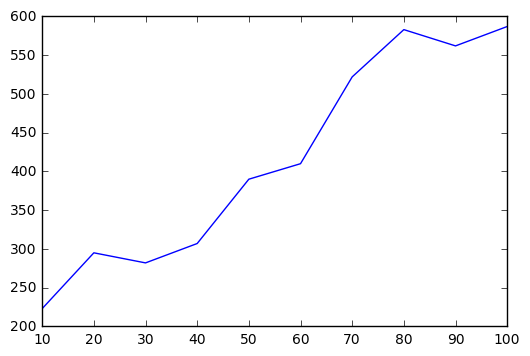

In [249]:
plot(sizes, times)

## Timing GET of 10 objects

In [250]:
%%time

for i in range(10):
    get_object(storage_url, token, 'container1','file{}.txt'.format(i), s)

CPU times: user 170 ms, sys: 10.5 ms, total: 180 ms
Wall time: 1.69 s


## Timing GET of /info

In [251]:
%%time
for i in range(10):
     s.get('https://swift.oit.duke.edu/info')

CPU times: user 167 ms, sys: 9.83 ms, total: 177 ms
Wall time: 1.42 s


## Confirming with bash

In [255]:
%%bash

time curl https://swift.oit.duke.edu/info 


{"formpost": {}, "slo": {"max_manifest_segments": 1000, "min_segment_size": 1, "max_manifest_size": 2097152}, "crossdomain": {}, "staticweb": {}, "tempurl": {"methods": ["GET", "HEAD", "PUT", "POST", "DELETE"]}, "swift": {"max_file_size": 5368709122, "account_listing_limit": 10000, "account_autocreate": true, "max_meta_count": 90, "max_meta_value_length": 256, "container_listing_limit": 10000, "max_meta_overall_size": 4096, "version": "2.3.0", "max_meta_name_length": 128, "max_header_size": 8192, "policies": [{"default": true, "name": "Policy-0"}], "max_object_name_length": 1024, "max_account_name_length": 256, "strict_cors_mode": true, "allow_account_management": true, "max_container_name_length": 256}}

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   713  100   713    0     0   4993      0 --:--:-- --:--:-- --:--:--  5056

real	0m0.153s
user	0m0.015s
sys	0m0.005s


## Ping/latency info

In [257]:
%%bash

ping -c 10 swift.oit.duke.edu

PING swift-fitz.oit.duke.edu (152.3.72.68): 56 data bytes
64 bytes from 152.3.72.68: icmp_seq=0 ttl=247 time=0.663 ms
64 bytes from 152.3.72.68: icmp_seq=1 ttl=247 time=0.967 ms
64 bytes from 152.3.72.68: icmp_seq=2 ttl=247 time=0.948 ms
64 bytes from 152.3.72.68: icmp_seq=3 ttl=247 time=0.920 ms
64 bytes from 152.3.72.68: icmp_seq=4 ttl=247 time=0.703 ms
64 bytes from 152.3.72.68: icmp_seq=5 ttl=247 time=0.994 ms
64 bytes from 152.3.72.68: icmp_seq=6 ttl=247 time=0.733 ms
64 bytes from 152.3.72.68: icmp_seq=7 ttl=247 time=0.745 ms
64 bytes from 152.3.72.68: icmp_seq=8 ttl=247 time=0.902 ms
64 bytes from 152.3.72.68: icmp_seq=9 ttl=247 time=0.987 ms

--- swift-fitz.oit.duke.edu ping statistics ---
10 packets transmitted, 10 packets received, 0.0% packet loss
round-trip min/avg/max/stddev = 0.663/0.856/0.994/0.123 ms


On OIT desktop network, with sub 1ms ping to the host